# Apply CWT to the FHR signals

For an explanation of CWT, see `04_introduction_to_signal_transformation.ipynb` and `05_cwt_wavelets.ipynb`

This notebook applies CWT to the **last 20 minutes** of each of the cleaned FHR signals.

The signals have been adjusted by subtracting 140bpm from each timepoint (to try and centre around 0, as 140bpm is the middle of the normal range of FHR).

## Set up

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_fhr_clean'
    images = './outputs/scaleograms'


paths = Paths()

In [3]:
# Set up dictionary for signals
signals = dict()

# Get list of filenames and loop through them
filenames = os.listdir(paths.data)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        signals[filename_short] = pd.read_csv(os.path.join(paths.data, file))['FHR']

## Define CWT function

**Note:** It's been a steep learning curve understanding these transformations, and I'm not certain that I've used the best parameters here.

In [4]:
def fhr_scaleogram(record, scales, show=False):
    '''
    Perform CWT with signal.morlet2 wavelet using provided scales
    Inputs:
    - record - string, name of record from dictionary of FHR signals
    - scales - array containing each of the wavelet scales to use
    - show - boolean, if true print figure
    '''
    # Get the last 20 minutes of the chosen record
    sig = signals[record].tail(20*60*4) - 140

    # Perform CWT
    cwtmatr = signal.cwt(sig, signal.morlet2, scales)

    # Plot the scaleogram
    fig, ax = plt.subplots()
    magn = np.absolute(cwtmatr)
    ax.imshow(
        magn,
        extent=[min(sig.index), max(sig.index), scales.min(), scales.max()],
        aspect='auto',
    )
    plt.axis('off')
    plt.savefig(f'{paths.images}/{record}.png',
                bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close(fig)

In [5]:
# Generate a log scale
log_scale = np.geomspace(start=1, stop=50, num=50)
log_scale

array([ 1.        ,  1.08311073,  1.17312885,  1.27062844,  1.37623129,
        1.49061088,  1.61449663,  1.74867862,  1.89401257,  2.05142534,
        2.22192079,  2.40658624,  2.60659937,  2.82323575,  3.05787692,
        3.3120193 ,  3.58728363,  3.88542538,  4.20834591,  4.5581046 ,
        4.93693199,  5.347244  ,  5.79165734,  6.27300619,  6.7943603 ,
        7.35904453,  7.97066007,  8.63310743,  9.35061127, 10.12774737,
       10.96947182, 11.88115261, 12.86860384, 13.93812287, 15.0965304 ,
       16.35121402, 17.71017531, 19.18208087, 20.77631756, 22.50305243,
       24.37329749, 26.39897997, 28.5930184 , 30.96940496, 33.54329473,
       36.33110236, 39.3506067 , 42.62106425, 46.1633319 , 50.        ])

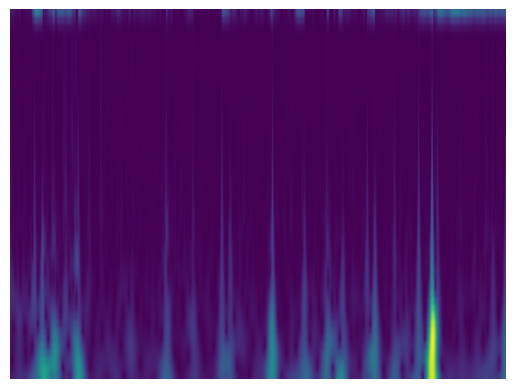

In [6]:
fhr_scaleogram('1001', scales=log_scale, show=True)

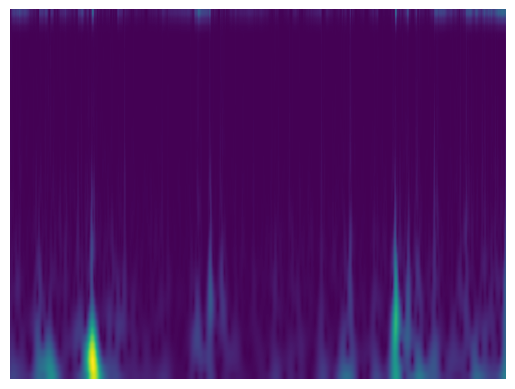

In [7]:
fhr_scaleogram('1463', scales=log_scale, show=True)

## Apply CWT to the signals and save the scaleograms

In [8]:
for key, value in signals.items():
    fhr_scaleogram(record=key, scales=log_scale)